In [3]:
import flax.linen as nn
from flax.core.frozen_dict import freeze, unfreeze

import jax
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp
import optax
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import seaborn as sns

from bijax.advi import ADVI
from bijax.core import transform_dist_params
from bijax.utils import train_fn, initialize_params

from functools import partial
import regdata as rd

init = 0

## Prepare dataset

In [4]:
def load_multinoise(seed):
    N = 100
    key, subkey = jax.random.split(seed)
    X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5).reshape(-1, 1)
    X_test = jax.random.uniform(key, shape=(200, 1), minval=-0.5, maxval=1.0).reshape(-1, 1)
    def f(seed, x):
        epsilons = jax.random.normal(seed, shape=(3,)) * 0.02
        return x + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0])) + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1])) + epsilons[2]
    target_vmap = jax.vmap(f)
    keys = jax.random.split(subkey, X.shape[0])
    y = target_vmap(keys, X)# + jax.random.normal(subkey, shape=(X.shape[0], 1))*0.02
    idx = jnp.argsort(X.ravel())
    return X[idx], y[idx].ravel(), X_test.sort(axis=0)

((100, 1), (100,))

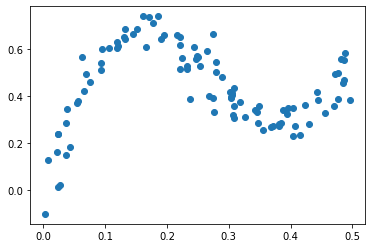

In [5]:
seed = jax.random.PRNGKey(init)
X, y, X_test = load_multinoise(seed)
# X, y, X_test = rd.SineNoisy().get_data()

plt.scatter(X, y);
X.shape, y.shape

## Define and initialize NN

In [6]:
class MLP(nn.Module):
    layers: list
    @nn.compact
    def __call__(self, x):
        for num_features in self.layers:
            x = nn.relu(nn.Dense(num_features)(x))
        return x

class Linear(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1)(x)
        return x.ravel()

mlp = MLP([16])
linear = Linear()

In [7]:
mlp_out = mlp.apply(mlp.init(seed, X), X)
linear_out = linear.apply(linear.init(seed, mlp_out), mlp_out)
linear_out.shape

(100,)

## Initialize NN parameters

In [8]:
seed = jax.random.PRNGKey(init+1)
frozen_params = linear.init(seed, mlp_out)
frozen_params

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.34015724],
                         [ 0.35990006],
                         [-0.29169452],
                         [ 0.13812357],
                         [-0.06816821],
                         [ 0.02852958],
                         [-0.00667705],
                         [-0.2687957 ],
                         [-0.09560655],
                         [ 0.4854728 ],
                         [ 0.10001474],
                         [ 0.5217002 ],
                         [-0.03545877],
                         [-0.05049552],
                         [-0.5000216 ],
                         [ 0.0288471 ]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})

We need to unfreeze the parameters to use outside of `flax`.

In [9]:
params = unfreeze(frozen_params)
params

{'params': {'Dense_0': {'bias': DeviceArray([0.], dtype=float32),
   'kernel': DeviceArray([[-0.34015724],
                [ 0.35990006],
                [-0.29169452],
                [ 0.13812357],
                [-0.06816821],
                [ 0.02852958],
                [-0.00667705],
                [-0.2687957 ],
                [-0.09560655],
                [ 0.4854728 ],
                [ 0.10001474],
                [ 0.5217002 ],
                [-0.03545877],
                [-0.05049552],
                [-0.5000216 ],
                [ 0.0288471 ]], dtype=float32)}}}

## Define $\mathcal{N}(0, 1)$ prior for all NN parameters

Note that `tfd.Independent` will convert all batch dimensions to event dimensions so that each prior distribution can return a scalar log prob.

In [10]:
prior = jax.tree_map(
    lambda param: tfd.Independent(
        tfd.Normal(loc=jnp.zeros(param.shape), scale=jnp.ones(param.shape)),
        reinterpreted_batch_ndims=len(param.shape),
    ),
    params,
)
prior

{'params': {'Dense_0': {'bias': <tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[1] dtype=float32>,
   'kernel': <tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[16, 1] dtype=float32>}}}

No change of variable is needed for this model, thus we set `tfd.Identity()` bijector.

In [11]:
bijector = jax.tree_map(lambda param: tfb.Identity(), params)
bijector

{'params': {'Dense_0': {'bias': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>,
   'kernel': <tfp.bijectors.Identity 'identity' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>}}}

## Define log likelihood function

In [12]:
def log_likelihood_fn(latent_sample, outputs, inputs, **kwargs):
    frozen_params_linear = freeze(latent_sample)
    frozen_params_mlp = freeze(kwargs["mlp_params"])
    mlp_out = mlp.apply(frozen_params_mlp, inputs['X'])
    y_pred = linear.apply(frozen_params_linear, mlp_out)
    scale = jnp.exp(kwargs["log_noise_scale"])
    return tfd.Normal(loc=y_pred, scale=scale).log_prob(outputs).sum()

## Initialize the ADVI model

In [13]:
model = ADVI(prior, bijector, log_likelihood_fn, vi_type="mean_field")

## Initialize the parameters

In [14]:
params = model.init(jax.random.PRNGKey(init + 2))
params["log_noise_scale"] = jnp.log(0.001)
params["mlp_params"] = unfreeze(mlp.init(jax.random.PRNGKey(init-2), X))

## Fit the model

In [16]:
%%time
tx = optax.adam(learning_rate=0.001)
seed1 = jax.random.PRNGKey(init + 4)
seed2 = jax.random.PRNGKey(init + 5)

loss_fn = partial(model.loss_fn, inputs={"X": X}, outputs=y, full_data_size=len(y), n_samples=100)
results = train_fn(
    loss_fn,
    params,
    n_epochs=20000,
    optimizer=tx,
    seed=seed2,
    return_args={"losses"},
)

CPU times: user 7.35 s, sys: 1.34 s, total: 8.69 s
Wall time: 6.65 s


In [17]:
results

{'params': {'log_noise_scale': DeviceArray(-3.6541853, dtype=float32),
  'mlp_params': {'params': {'Dense_0': {'bias': DeviceArray([ 0.        ,  0.        , -0.15914324,  0.        ,
                  -0.34641784, -0.30050346, -0.38571617,  0.        ,
                   0.        ,  0.        ,  0.        ,  0.        ,
                   0.15448804,  0.        , -0.00669614, -0.30679905],            dtype=float32),
     'kernel': DeviceArray([[-0.01561241, -0.7494856 ,  0.95457   , -1.3324082 ,
                    0.8921254 ,  0.61364335,  0.7853247 , -0.87009794,
                   -1.4571064 , -0.5685537 , -1.7247839 , -1.0837975 ,
                    0.99790084, -0.854734  ,  0.01346357,  0.6237599 ]],            dtype=float32)}}},
  'posterior': <tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[17] dtype=float32>},
 'losses': DeviceArray([6.6277651e+08, 8.0289677e+08, 6.4402413e+08, ...,
              2.0044613e+03, 2.0669446e+03, 2.4

Check the loss

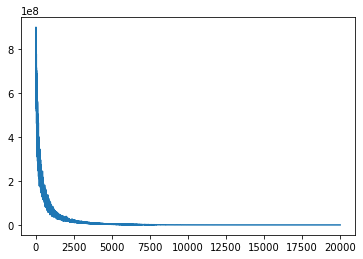

In [18]:
plt.plot(results['losses']);

## Get the posterior distribution

In [19]:
posterior = model.apply(results["params"])

## Draw samples from the posterior

We now generate the samples from the predictive distribution.

In [20]:
seed = jax.random.PRNGKey(init+6)
weights = posterior.sample(seed, sample_shape=(1000,))
def draw_sample(weights):
    mlp_out = mlp.apply(freeze(results["params"]["mlp_params"]), X_test)
    y_pred = linear.apply(freeze(weights), mlp_out)
    return y_pred
y_samples = jax.vmap(draw_sample)(weights)
y_samples.shape

(1000, 200)

## Visualizing the fit

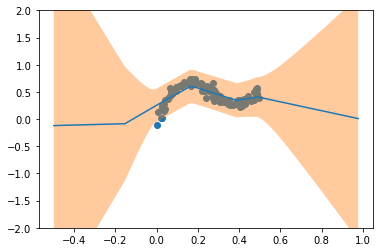

In [21]:
y_mean = y_samples.mean(axis=0)
y_std = y_samples.std(axis=0)

noise_scale = jnp.exp(results["params"]["log_noise_scale"])
plt.scatter(X, y);
plt.plot(X_test, y_mean);
plt.fill_between(X_test.ravel(), y_mean-2*y_std-noise_scale, y_mean+2*y_std+noise_scale, alpha=0.4);
plt.ylim(-2, 2);